In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import re # For regular expressions
from scipy.stats import zscore, mannwhitneyu # Added mannwhitneyu for p-value calculation
from statsmodels.sandbox.stats.multicomp import multipletests # Added for BH correction
# --- Configuration ---

# 1. Path to your FULL annotated AnnData file (containing all genotypes and conditions)
adata_file = '/mnt/data/project/25_04_29_Figure3_reanalysis/processed_data/merged_v9/Annotated_phenotype_hypr_seq_MERGED_with_donor_clusters.h5ad'

# 2. Column names
genotype_col = 'genotype_annotation'
condition_col = 'condition'

# 3. Condition labels (UPDATE THESE to match your data exactly)
control_condition_label = 'PBS' # e.g., PBS
stimulated_condition_label = 'IFNG' # e.g., IFN-gamma

# 4. Wild-Type / Baseline Genotype Label (UPDATE if needed)
wt_genotype_label = 'AAV_control' # e.g., AAV_control, unedited, or mixed

# 5. Parameters for DE analysis and scoring
# n_top_genes = 100 # Number of top up/down genes for score
# de_logfc_threshold = 0 # Log fold change threshold for DE (can be 0 if using rank)

donor = "0" 
gene_list = "Top 100"

# 6. Output directory and file name for the table
output_dir = Path(f'./{donor}_{gene_list}')
output_dir.mkdir(parents=True, exist_ok=True)

assert donor in ["0", "1", "all"]
assert gene_list in ["Top 50", "Top 100", "Top 200", "Top FC"]

output_table_file = output_dir / f'all_cells_ifng_vs_{wt_genotype_label}_donor_{donor}_response_scanpy_scores.csv'


In [2]:
# --- Load Data ---
print(f"Loading full annotated data from: {adata_file}")
try:
    if isinstance(adata_file, (str, Path)):
        adata_full = sc.read_h5ad(adata_file)
        # sc.pp.filter_cells(adata_full, min_counts=1000)
    elif isinstance(adata_file, sc.AnnData):
        adata_full = adata_file # Use the object directly if passed
    else:
        raise TypeError("adata_file must be a path string or an AnnData object.")

    print("Full data loaded successfully:")
    print(adata_full)

    # Check necessary columns
    required_obs_cols = [genotype_col, condition_col]
    for col in required_obs_cols:
        if col not in adata_full.obs.columns:
            raise ValueError(f"Required column '{col}' not found in adata_full.obs.")

    # Prepare expression data for DE and scoring (log-normalized)
    if 'log1p' in adata_full.uns and adata_full.X is not None:
        adata_processed = adata_full.copy() # Assumes adata_full.X is log-normalized
        print("Using expression from adata_full.X (assumed log-normalized).")
    elif adata_full.raw is not None:
        print("Using adata_full.raw for processing...")
        adata_processed = adata_full.raw.to_adata()
        sc.pp.normalize_total(adata_processed, target_sum=1e4)
        sc.pp.log1p(adata_processed)
        print("  Normalization and log1p applied to raw data.")
    elif adata_full.X is not None:
        print("Using adata_full.X for processing (will normalize and log1p)...")
        adata_processed = adata_full.copy()
        sc.pp.normalize_total(adata_processed, target_sum=1e4)
        sc.pp.log1p(adata_processed)
        print("  Normalization and log1p applied to .X data.")
    else:
        raise ValueError("Suitable expression data not found in .X or .raw for processing.")


except FileNotFoundError:
    print(f"Error: AnnData file not found at {adata_file}.")
    exit()
except (ValueError, TypeError) as ve:
     print(f"Error: {ve}")
     exit()
except Exception as e:
    print(f"An error occurred loading/preparing the AnnData file: {e}")
    exit()

if donor !="all":
    adata_processed = adata_processed[adata_processed.obs["inferred_donor_cluster"] == donor].copy() # Filter to specific donor if needed

adata_full = adata_processed.copy()
# --- Step 1: Identify IFN-g Signature Genes using WT cells from adata_processed ---
print("\nStep 1: Identifying IFN-g signature genes using WT cells...")

# Subset to WT cells from the processed data
adata_wt_processed = adata_processed[adata_processed.obs[genotype_col] == wt_genotype_label].copy()

# Ensure condition is categorical for DE analysis
adata_wt_processed.obs[condition_col] = adata_wt_processed.obs[condition_col].astype('category')

# Check if both conditions exist in WT subset
if control_condition_label not in adata_wt_processed.obs[condition_col].cat.categories or \
   stimulated_condition_label not in adata_wt_processed.obs[condition_col].cat.categories:
   print(f"Error: WT cells lack data for both '{control_condition_label}' and '{stimulated_condition_label}'. Cannot perform DE.")
   # Attempt to use all cells for DE as a fallback if WT is insufficient, though less ideal
   print("Attempting DE on all cells as a fallback (less ideal)...")
   adata_de_source = adata_processed.copy()
   adata_de_source = adata_de_source[adata_de_source.obs["genotype_annotation"]=="unedited"]

   adata_de_source.obs[condition_col] = adata_de_source.obs[condition_col].astype('category')
   if control_condition_label not in adata_de_source.obs[condition_col].cat.categories or \
      stimulated_condition_label not in adata_de_source.obs[condition_col].cat.categories:
      print("Error: Fallback DE also failed. Both conditions not present in the full dataset.")
      exit()
else:
    adata_de_source = adata_wt_processed # Use WT cells for DE


Loading full annotated data from: /mnt/data/project/25_04_29_Figure3_reanalysis/processed_data/merged_v9/Annotated_phenotype_hypr_seq_MERGED_with_donor_clusters.h5ad
Full data loaded successfully:
AnnData object with n_obs × n_vars = 46913 × 1276
    obs: 'n_counts', 'condition', 'batch', 'sample_name', 'sample_key', 'AAV_control', 'JAK1-R360W_het_bystander', 'JAK1-R360W_het_pure', 'JAK1-R360W_hom_bystander', 'JAK1-R360W_hom_pure', 'JAK1-T147A_het_bystander', 'JAK1-T147A_het_pure', 'JAK1-T147A_hom_bystander', 'JAK1-T147A_hom_pure', 'JAK1-SPA5_het_bystander', 'JAK1-SPA5_het_pure', 'JAK1-SPA5_hom_bystander', 'JAK1-SPA5_hom_pure', 'JAK1-E83K_het_bystander', 'JAK1-E83K_het_pure', 'JAK1-E83K_hom_bystander', 'JAK1-E83K_hom_pure', 'STAT1-L600P_het_bystander', 'STAT1-L600P_het_pure', 'STAT1-L600P_hom_bystander', 'STAT1-L600P_hom_pure', 'STAT1-A402T_het_bystander', 'STAT1-A402T_het_pure', 'STAT1-A402T_hom_bystander', 'STAT1-A402T_hom_pure', 'STAT1-A401T_het_bystander', 'STAT1-A401T_het_pure', '

In [3]:
genelist_file = pd.read_csv("/mnt/data/project/25_04_29_Figure3_reanalysis/src/analysis_results_v8/Gene sets for program score.csv")
up_genes = genelist_file[f'{gene_list} up'].dropna().tolist()
down_genes = genelist_file[f'{gene_list} Down'].dropna().tolist()


sc.tl.score_genes(adata_processed, gene_list=up_genes, score_name='ifng_score_up', use_raw=False)
sc.tl.score_genes(adata_processed, gene_list=down_genes, score_name='ifng_score_down', use_raw=False)

# Assign scores back to the original adata_full object, aligning by obs_names
adata_full.obs['ifng_response_score_raw'] = adata_processed.obs['ifng_score_up'].reindex(adata_full.obs_names) - \
                                           adata_processed.obs['ifng_score_down'].reindex(adata_full.obs_names)



print("  Raw scores calculated for all cells.")

# --- Step 3: Normalize (Z-score) the Scores ---
print("\nStep 3: Normalizing (z-scoring) the scores across all cells...")
# Z-score across all cells in adata_full
adata_full.obs['ifng_response_score_z'] = zscore(adata_full.obs['ifng_response_score_raw'].dropna()) # dropna before zscore
print("  Scores z-scored.")
print(adata_full.obs[['ifng_response_score_raw', 'ifng_response_score_z']].describe())


# --- Step 3.1: Calculate IFN-g Response Scores for Stimulated and Control Groups ---
print("\nStep 3.1: Calculating IFN-g response scores for stimulated and control groups...")
# Create a copy of the adata_full for scoring
adata_scoring = adata_full.copy()
adata_stim = adata_scoring[adata_scoring.obs[condition_col] == stimulated_condition_label].copy()
adata_control = adata_scoring[adata_scoring.obs[condition_col] == control_condition_label].copy()
# Calculate scores for stimulated and control separately
sc.tl.score_genes(adata_stim, gene_list=up_genes, score_name='ifng_score_up', use_raw=False)
sc.tl.score_genes(adata_stim, gene_list=down_genes, score_name='ifng_score_down', use_raw=False)
# Calculate the IFN-g response score for stimulated cells
adata_stim.obs['ifng_response_score_stim_group'] = adata_stim.obs['ifng_score_up'] - adata_stim.obs['ifng_score_down']
# Calculate scores for control cells
sc.tl.score_genes(adata_control, gene_list=up_genes, score_name='ifng_score_up', use_raw=False)
sc.tl.score_genes(adata_control, gene_list=down_genes, score_name='ifng_score_down', use_raw=False)
# Calculate the IFN-g response score for control cells
adata_control.obs['ifng_response_score_control_group'] = adata_control.obs['ifng_score_up'] - adata_control.obs['ifng_score_down']

# map the scores back to the original adata object
# note that the size of the adata_stim and adata_control may not match the original adata
adata_scoring.obs['ifng_response_score_stim_group'] = adata_stim.obs['ifng_response_score_stim_group'].reindex(adata_scoring.obs_names)
adata_scoring.obs['ifng_response_score_control_group'] = adata_control.obs['ifng_response_score_control_group'].reindex(adata_scoring.obs_names)


# add the Ander's version scores as a baseline
# 1st, he only computed the scores for the IFN-g stimulated cells, so we will use the same approach
# 2, he use the simply gene expression values, not from scanpy's score_genes

IFNg_anders_score = adata_stim[:, up_genes].X.mean(axis=1) - adata_stim[:, down_genes].X.mean(axis=1)
# add the Anders' score to the adata_scoring
adata_stim.obs['ifng_response_score_anders'] = IFNg_anders_score
adata_scoring.obs['ifng_response_score_anders'] = adata_stim.obs['ifng_response_score_anders'].reindex(adata_scoring.obs_names)


  Raw scores calculated for all cells.

Step 3: Normalizing (z-scoring) the scores across all cells...
  Scores z-scored.
       ifng_response_score_raw  ifng_response_score_z
count             35960.000000           3.596000e+04
mean                  0.381472           2.529184e-17
std                   0.874356           1.000014e+00
min                  -1.289184          -1.910754e+00
25%                  -0.557305          -1.073694e+00
50%                   0.751347           4.230306e-01
75%                   1.176222           9.089670e-01
max                   2.148193           2.020625e+00

Step 3.1: Calculating IFN-g response scores for stimulated and control groups...


In [4]:
# --- Step 4: Create and Save Output Table ---
print("\nStep 4: Creating and saving the output table...")

# Select relevant columns for the output table
# save the adata_scoring related response scores
ifng_response_cols = ['ifng_response_score_raw', 'ifng_response_score_z',
                      'ifng_response_score_stim_group', 'ifng_response_score_control_group',
                      'ifng_response_score_anders']
output_df = adata_scoring.obs[[genotype_col, condition_col] + ifng_response_cols].copy()
#  output_df = adata_full.obs[[genotype_col, condition_col, 'ifng_response_score_raw', 'ifng_response_score_z']].copy()
output_df.index.name = 'cell_barcode' # Set cell barcode as index name

try:
    output_df.to_csv(output_table_file)
    print(f"Successfully saved IFN-g response scores to: {output_table_file}")
except Exception as e:
    print(f"Error saving table to CSV: {e}")

print("\n--- IFN-g Score Calculation for All Cells Complete ---")




Step 4: Creating and saving the output table...
Successfully saved IFN-g response scores to: 0_Top 100/all_cells_ifng_vs_AAV_control_donor_0_response_scanpy_scores.csv

--- IFN-g Score Calculation for All Cells Complete ---


In [5]:
# Add the code for get the per genotype score and compute the p_val
def analyze_ifng_scores_per_genotype(
    score_data_df,
    genotype_col_name,
    condition_col_name,
    wt_genotype_label_ref,
    score_cols_to_analyze,
    min_cells_for_test=3,
    output_dir_path=Path('./analysis_results/ifng_score_pvals')
):
    """
    Aggregates IFN-g scores per genotype/condition and computes p-values
    for each genotype's score distribution compared against the WT (AAV_control)
    genotype within the same condition.

    Args:
        score_data_df (pd.DataFrame): DataFrame containing cell-level scores and metadata.
                                      Assumes it has 'cell_barcode' as index.
        genotype_col_name (str): Name of the column with genotype annotations.
        condition_col_name (str): Name of the column with condition labels (e.g., 'PBS', 'IFNG').
        wt_genotype_label_ref (str): The label for the wild-type/control genotype (e.g., 'AAV_control').
        score_cols_to_analyze (list): List of score column names to analyze (e.g., ['ifng_response_score_raw', ...]).
        min_cells_for_test (int): Minimum number of cells required in a group for a statistical test.
        output_dir_path (Path): Path to directory for saving results.
    
    Returns:
        pd.DataFrame: A DataFrame summarizing mean/std and p-values for each genotype-score-condition comparison.
                      Returns None if no comparisons are made.
    """
    print("\n--- Starting Per-Genotype IFN-g Score Analysis ---")
    output_dir_path.mkdir(parents=True, exist_ok=True) # Ensure output directory exists

    all_summary_data = [] # To collect mean/std for all groups
    p_value_results = {}  # To collect p-values: { 'row_label': {genotype: pval, ...} }

    unique_genotypes = sorted([g for g in score_data_df[genotype_col_name].unique() if pd.notna(g)]) # Handle potential NaNs
    unique_conditions = sorted([c for c in score_data_df[condition_col_name].unique() if pd.notna(c)])

    print(f"  Genotypes found: {unique_genotypes}")
    print(f"  Conditions found: {unique_conditions}")
    print(f"  Reference WT genotype: {wt_genotype_label_ref}")

    # Prepare data for all comparisons
    for score_col in score_cols_to_analyze:
        if score_col not in score_data_df.columns:
            print(f"Warning: Score column '{score_col}' not found in input DataFrame. Skipping.")
            continue
        
        print(f"\n  Processing score: {score_col}")
        
        # Determine conditions relevant for this score
        if score_col == 'ifng_response_score_stim_group':
            conditions_for_this_score = [cond for cond in unique_conditions if cond == stimulated_condition_label]
            print(f"    (This score is specific to '{stimulated_condition_label}' cells only)")
        elif score_col == 'ifng_response_score_control_group':
            conditions_for_this_score = [cond for cond in unique_conditions if cond == control_condition_label]
            print(f"    (This score is specific to '{control_condition_label}' cells only)")
        elif score_col == 'ifng_response_score_anders': # Anders score is based on stim cells
             conditions_for_this_score = [cond for cond in unique_conditions if cond == stimulated_condition_label]
             print(f"    (Anders score is specific to '{stimulated_condition_label}' cells only)")
        else: # For raw and z scores, they are global
            conditions_for_this_score = unique_conditions
        
        for current_cond in conditions_for_this_score:
            print(f"    Condition: {current_cond}")
            
            # Extract WT data for this score and condition
            wt_scores_current_cond = score_data_df[
                (score_data_df[genotype_col_name] == wt_genotype_label_ref) &
                (score_data_df[condition_col_name] == current_cond)
            ][score_col].dropna()

            # Store WT's mean and std
            wt_mean = wt_scores_current_cond.mean() if len(wt_scores_current_cond) > 0 else np.nan
            wt_std = wt_scores_current_cond.std() if len(wt_scores_current_cond) >= 2 else 0
            all_summary_data.append({
                'Genotype': wt_genotype_label_ref,
                'Condition': current_cond,
                'Score_Source': score_col,
                'Mean_Score': wt_mean,
                'Std_Score': wt_std,
                'N_Cells': len(wt_scores_current_cond),
                'P_val_vs_WT': np.nan # WT has no p-val against itself
            })

            if len(wt_scores_current_cond) < min_cells_for_test:
                print(f"      Warning: Insufficient WT cells ({len(wt_scores_current_cond)}) for testing in {current_cond}. Skipping comparisons for this score/condition.")
                continue

            for current_geno in unique_genotypes:
                if current_geno == wt_genotype_label_ref:
                    continue # Skip comparing WT to itself

                # Extract current genotype's data for this score and condition
                geno_scores_current_cond = score_data_df[
                    (score_data_df[genotype_col_name] == current_geno) &
                    (score_data_df[condition_col_name] == current_cond)
                ][score_col].dropna()
                
                geno_mean = geno_scores_current_cond.mean() if len(geno_scores_current_cond) > 0 else np.nan
                geno_std = geno_scores_current_cond.std() if len(geno_scores_current_cond) >= 2 else 0

                all_summary_data.append({
                    'Genotype': current_geno,
                    'Condition': current_cond,
                    'Score_Source': score_col,
                    'Mean_Score': geno_mean,
                    'Std_Score': geno_std,
                    'N_Cells': len(geno_scores_current_cond),
                    'P_val_vs_WT': np.nan # Placeholder for now, computed later
                })

                # Perform test and store p-value
                row_key = f"{current_cond}_{score_col}"
                col_key = current_geno # Genotypes are columns in the p-value table
                
                if row_key not in p_value_results:
                    p_value_results[row_key] = {}
                
                if len(geno_scores_current_cond) < min_cells_for_test:
                    print(f"        Skipping '{current_geno}': Insufficient cells ({len(geno_scores_current_cond)}) for test.")
                    p_value_results[row_key][col_key] = np.nan
                    continue

                try:
                    stat, p_val = mannwhitneyu(wt_scores_current_cond, geno_scores_current_cond,
                                               alternative='two-sided', nan_policy='propagate')
                    p_value_results[row_key][col_key] = p_val
                except ValueError as ve: # e.g. if all values are identical in one group
                    print(f"        Warning: Test failed for {current_geno} vs {wt_genotype_label_ref} ({score_col}, {current_cond}): {ve}")
                    p_value_results[row_key][col_key] = np.nan

    # --- Apply Benjamini-Hochberg Correction to all p-values ---
    print("\n  Applying Benjamini-Hochberg (FDR) correction to p-values...")
    
    # Flatten all raw p-values from the dictionary
    raw_pvals_list = []
    keys_list = [] # Store keys to map back corrected p-values
    
    for r_key, geno_p_dict in p_value_results.items():
        for c_key, pval in geno_p_dict.items():
            if pd.notna(pval):
                raw_pvals_list.append(pval)
                keys_list.append((r_key, c_key))
                
    if raw_pvals_list:
        reject, p_values_corrected, _, _ = multipletests(raw_pvals_list, alpha=0.05, method='fdr_bh')
        
        # Map corrected p-values back to the dictionary
        for i, (r_key, c_key) in enumerate(keys_list):
            p_value_results[r_key][c_key] = p_values_corrected[i]
        print("  FDR correction applied successfully.")
    else:
        print("  No raw p-values to correct.")

    # --- Create Mean/Std Summary Table ---
    summary_df = pd.DataFrame(all_summary_data)
    # Pivot to have Genotypes as columns and (Condition_Score_Source) as index for easier viewing
    summary_pivot_mean = summary_df.pivot_table(index=['Condition', 'Score_Source'], 
                                              columns='Genotype', values='Mean_Score')
    summary_pivot_std = summary_df.pivot_table(index=['Condition', 'Score_Source'], 
                                             columns='Genotype', values='Std_Score')
    summary_pivot_n = summary_df.pivot_table(index=['Condition', 'Score_Source'], 
                                             columns='Genotype', values='N_Cells')
                                             
    print("\n--- Summary Table (Mean Scores) ---")
    print(summary_pivot_mean.head())

    # --- Create P-value Table ---
    p_value_df = pd.DataFrame.from_dict(p_value_results, orient='index')
    p_value_df.index.name = "Condition_Score_Source"
    
    # Sort columns (genotypes) and rows
    p_value_df = p_value_df.reindex(sorted(p_value_df.columns), axis=1)
    p_value_df = p_value_df.sort_index()

    print("\n--- P-value Table (FDR-corrected) ---")
    print(p_value_df.head())

    # --- Save Results ---
    summary_pivot_mean.to_csv(output_dir_path / f"ifng_scores_mean_per_genotype_{donor}.csv")
    summary_pivot_std.to_csv(output_dir_path / f"ifng_scores_std_per_genotype_{donor}.csv")
    summary_pivot_n.to_csv(output_dir_path / f"ifng_scores_n_cells_per_genotype_{donor}.csv")
    p_value_df.to_csv(output_dir_path / f"ifng_scores_pvalues_vs_aavcontrol_FDR_corrected_{donor}.csv")
    
    print(f"\n  Mean/Std summary tables and P-value table saved to: {output_dir_path}")

    return p_value_df # Return the p-value DataFrame for potential further use

# --- Call the new function after saving the main output_df ---
print("\n--- Calling per-genotype score analysis function ---")
# Ensure output_df is available from the main script's scope
if 'output_df' in locals():
    ifng_score_p_values_table = analyze_ifng_scores_per_genotype(
        score_data_df=output_df,
        genotype_col_name=genotype_col,
        condition_col_name=condition_col,
        wt_genotype_label_ref=wt_genotype_label,
        score_cols_to_analyze=ifng_response_cols,
        output_dir_path=output_dir # Use the same output_dir from config
    )
else:
    print("Error: 'output_df' not found. Please ensure the main score calculation part runs first.")

print("\n--- Script Finished ---")



--- Calling per-genotype score analysis function ---

--- Starting Per-Genotype IFN-g Score Analysis ---
  Genotypes found: ['AAV_control', 'IFNGR1-C77Y_het_bystander', 'IFNGR1-C77Y_het_pure', 'IFNGR1-C77Y_hom_bystander', 'IFNGR1-C77Y_hom_pure', 'IFNGR1-E164K_het_bystander', 'IFNGR1-E164K_het_pure', 'IFNGR1-E164K_hom_bystander', 'IFNGR1-E164K_hom_pure', 'IFNGR1-H222R_het_bystander', 'IFNGR1-H222R_het_pure', 'IFNGR1-H222R_hom_bystander', 'IFNGR1-H222R_hom_pure', 'IFNGR1-I87T_het_bystander', 'IFNGR1-I87T_het_pure', 'IFNGR1-I87T_hom_bystander', 'IFNGR1-I87T_hom_pure', 'IFNGR1-NC2_het_bystander', 'IFNGR1-NC2_het_pure', 'IFNGR1-NC2_hom_bystander', 'IFNGR1-NC2_hom_pure', 'IFNGR1-SPA1_het_bystander', 'IFNGR1-SPA1_het_pure', 'IFNGR1-SPA1_hom_bystander', 'IFNGR1-SPA1_hom_pure', 'IFNGR1-W89R_het_bystander', 'IFNGR1-W89R_het_pure', 'IFNGR1-W89R_hom_bystander', 'IFNGR1-W89R_hom_pure', 'IFNGR2-D78N_het_bystander', 'IFNGR2-D78N_het_pure', 'IFNGR2-D78N_hom_bystander', 'IFNGR2-D78N_hom_pure', 'IFNGR2

Loading combined mean score table: /mnt/data/project/25_08_25_rebuttal_analysis/fig3_stat1_het_pval/0_Top 100/ifng_scores_mean_per_genotype_0.csv
Loading combined p-value table: /mnt/data/project/25_08_25_rebuttal_analysis/fig3_stat1_het_pval/0_Top 100/ifng_scores_pvalues_vs_aavcontrol_FDR_corrected_0.csv
Combined mean and p-value tables loaded successfully.
Baseline 'AAV_control' score for IFNG ifng_response_score_z: 0.7183

Processed combined data head (with relative scores):
                           raw_score   p_value  score_relative_to_aav
AAV_control                 0.718341  1.000000               0.000000
IFNGR1-C77Y_het_bystander   0.710166  0.110946              -0.008175
IFNGR1-C77Y_het_pure        0.753656  0.851998               0.035315
IFNGR1-C77Y_hom_bystander  -0.459751  0.000144              -1.178092
IFNGR1-C77Y_hom_pure       -0.047741  0.000841              -0.766082

--- Determining Global Y-axis Limits for consistent plotting ---
  Global Y-axis limits: [-1.92,

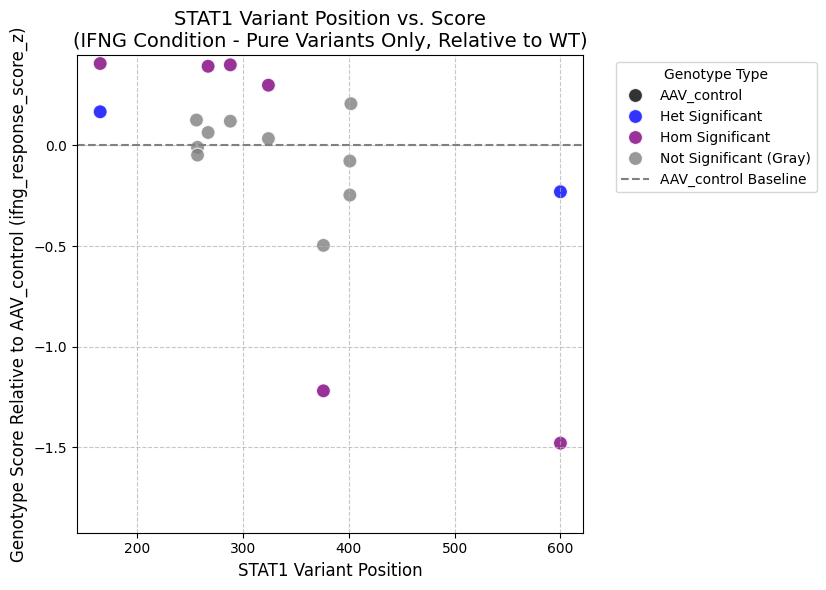


--- Generating plot for target gene: IFNGR1 ---

  Plotting data for IFNGR1 (head):
           genotype_label  position     score       p_value  allele_type  \
0             AAV_control       NaN  0.000000  1.000000e+00  AAV_control   
11   IFNGR1-SPA1_het_pure      30.0 -0.053412  5.629501e-01          het   
12   IFNGR1-SPA1_hom_pure      30.0 -1.748364  2.130389e-06          hom   
1    IFNGR1-C77Y_het_pure      77.0  0.035315  8.519983e-01          het   
2    IFNGR1-C77Y_hom_pure      77.0 -0.766082  8.407130e-04          hom   
7    IFNGR1-I87T_het_pure      87.0 -0.068790  5.574386e-05          het   
8    IFNGR1-I87T_hom_pure      87.0 -0.889134  1.555705e-87          hom   
13   IFNGR1-W89R_het_pure      89.0 -0.332839  1.277552e-02          het   
14   IFNGR1-W89R_hom_pure      89.0 -1.652037  1.162232e-68          hom   
9     IFNGR1-NC2_het_pure     125.0 -0.130016  8.810640e-03          het   
10    IFNGR1-NC2_hom_pure     125.0 -1.542883  6.679838e-67          hom   
3  

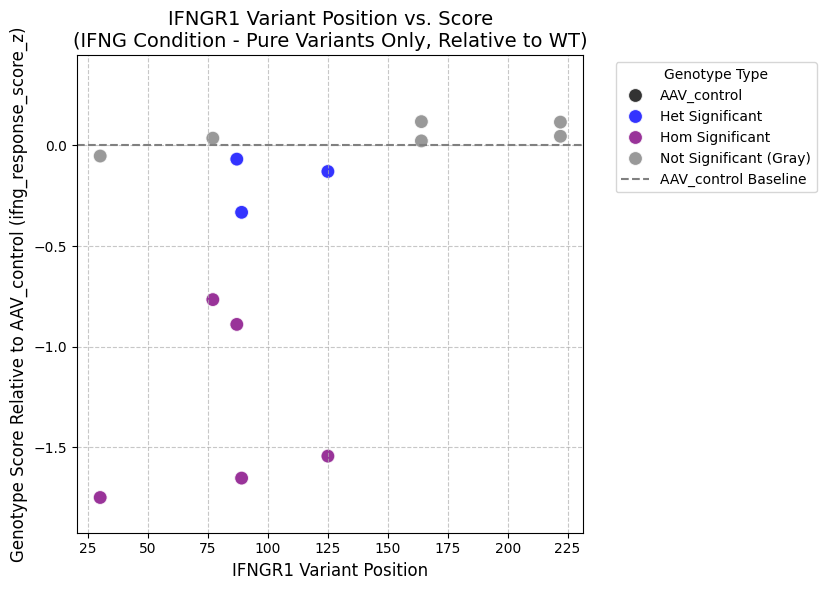


--- Generating plot for target gene: IFNGR2 ---

  Plotting data for IFNGR2 (head):
           genotype_label  position     score       p_value  allele_type  \
0             AAV_control       NaN  0.000000  1.000000e+00  AAV_control   
1    IFNGR2-D78N_het_pure      78.0  0.120945  4.733557e-01          het   
2    IFNGR2-D78N_hom_pure      78.0  0.249056  2.934440e-01          hom   
9    IFNGR2-Y82C_het_pure      82.0  0.051314  2.860832e-01          het   
10   IFNGR2-Y82C_hom_pure      82.0 -0.216875  2.607844e-15          hom   
3   IFNGR2-R136W_het_pure     136.0  0.065394  6.110166e-01          het   
4   IFNGR2-R136W_hom_pure     136.0 -0.014943  2.283757e-01          hom   
7    IFNGR2-SPD3_het_pure     157.0  0.050680  9.457351e-01          het   
8    IFNGR2-SPD3_hom_pure     157.0  0.188344  1.000000e+00          hom   
5   IFNGR2-R206G_het_pure     206.0  0.075811  7.681076e-01          het   
6   IFNGR2-R206G_hom_pure     206.0  0.173068  3.484630e-01          hom   

  

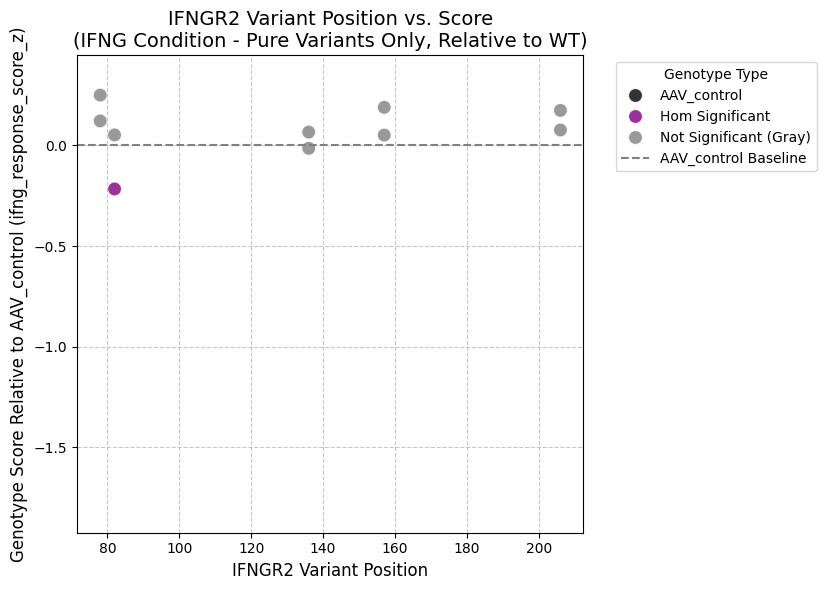


--- Generating plot for target gene: JAK1 ---

  Plotting data for JAK1 (head):
        genotype_label  position     score   p_value  allele_type  \
0          AAV_control       NaN  0.000000  1.000000  AAV_control   
1   JAK1-E83K_het_pure      83.0  0.081652  0.747726          het   
2   JAK1-E83K_hom_pure      83.0  0.210793  0.073478          hom   
5   JAK1-SPA5_het_pure     110.0 -0.042930  0.106400          het   
6   JAK1-SPA5_hom_pure     110.0 -1.007712  0.000001          hom   
7  JAK1-T147A_het_pure     147.0  0.091596  0.195461          het   
8  JAK1-T147A_hom_pure     147.0  0.190072  0.040934          hom   
3  JAK1-R360W_het_pure     360.0  0.092467  0.812954          het   
4  JAK1-R360W_hom_pure     360.0  0.060722  0.871057          hom   

      plot_color_category  
0             AAV_control  
1  Not Significant (Gray)  
2  Not Significant (Gray)  
5  Not Significant (Gray)  
6         Hom Significant  
7  Not Significant (Gray)  
8         Hom Significant  
3  N

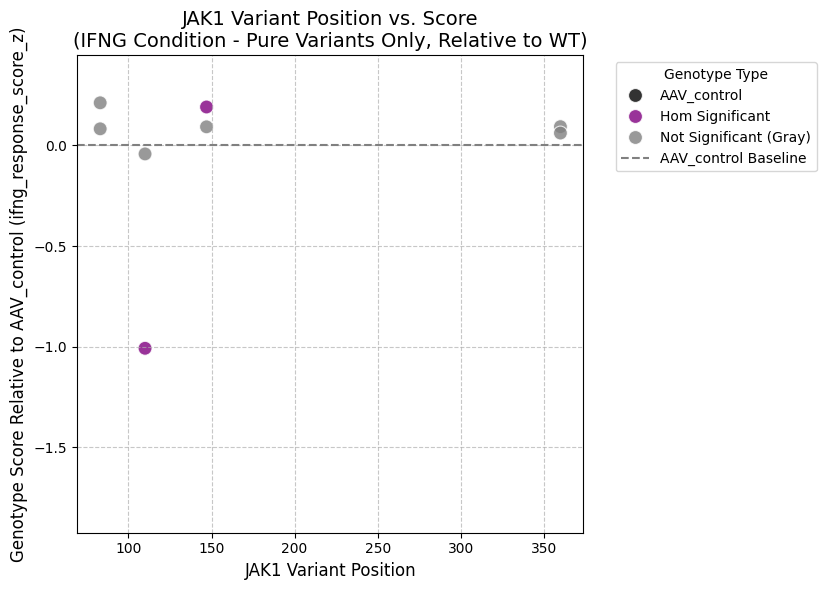


--- Generating plot for target gene: JAK2 ---

  Plotting data for JAK2 (head):
        genotype_label  position     score   p_value  allele_type  \
0          AAV_control       NaN  0.000000  1.000000  AAV_control   
1  JAK2-G281S_het_pure     281.0  0.047121  0.971435          het   
2  JAK2-G281S_hom_pure     281.0  0.003517  1.000000          hom   
3  JAK2-R683G_het_pure     683.0  0.018988  0.483527          het   
4  JAK2-R683G_hom_pure     683.0  0.178583  0.001533          hom   
5  JAK2-R867Q_het_pure     867.0  0.025180  0.824639          het   
6  JAK2-R867Q_hom_pure     867.0  0.260234  0.433427          hom   

      plot_color_category  
0             AAV_control  
1  Not Significant (Gray)  
2  Not Significant (Gray)  
3  Not Significant (Gray)  
4         Hom Significant  
5  Not Significant (Gray)  
6  Not Significant (Gray)  
  Applying global Y-axis limits: [-1.92, 0.45]


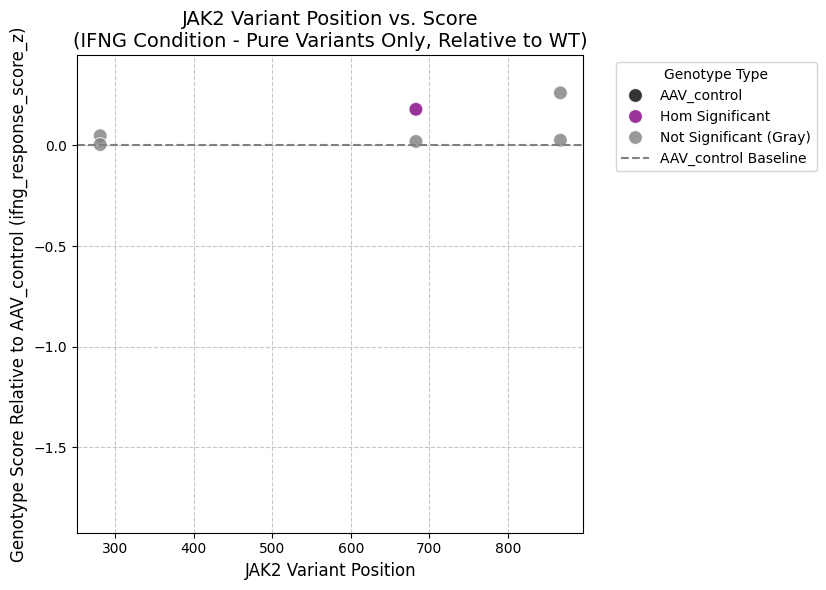


--- Generating plot for target gene: IRF1 ---

  Plotting data for IRF1 (head):
        genotype_label  position     score       p_value  allele_type  \
0          AAV_control       NaN  0.000000  1.000000e+00  AAV_control   
3   IRF1-W11R_het_pure      11.0  0.032074  4.518802e-01          het   
4   IRF1-W11R_hom_pure      11.0 -0.272957  1.271781e-23          hom   
1  IRF1-R129*_het_pure     129.0  0.070691  6.390397e-01          het   
2  IRF1-R129*_hom_pure     129.0 -0.045653  3.310950e-02          hom   

      plot_color_category  
0             AAV_control  
3  Not Significant (Gray)  
4         Hom Significant  
1  Not Significant (Gray)  
2         Hom Significant  
  Applying global Y-axis limits: [-1.92, 0.45]


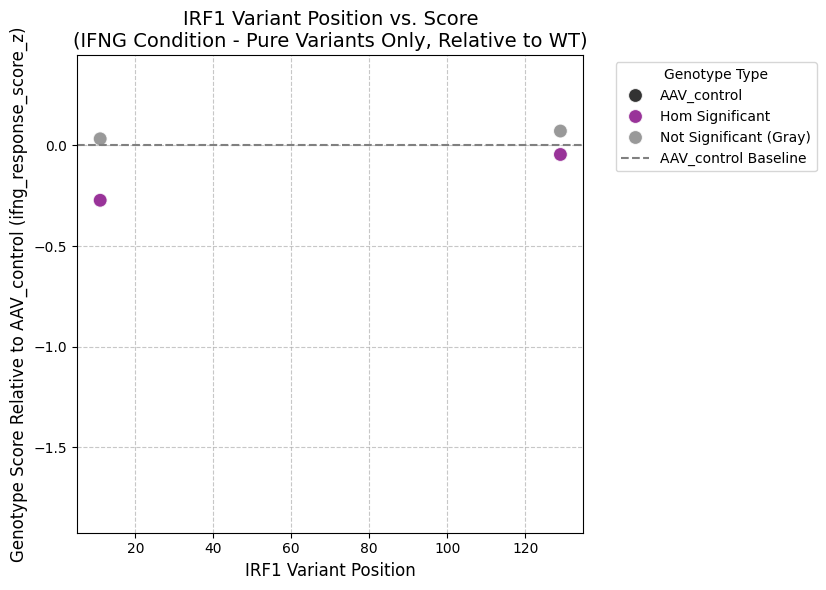


--- Genotype Position vs. Score Plots Generated Successfully ---
Loading combined mean score table: /mnt/data/project/25_08_25_rebuttal_analysis/fig3_stat1_het_pval/0_Top 100/ifng_scores_mean_per_genotype_0.csv
Loading combined p-value table: /mnt/data/project/25_08_25_rebuttal_analysis/fig3_stat1_het_pval/0_Top 100/ifng_scores_pvalues_vs_aavcontrol_FDR_corrected_0.csv
Combined mean and p-value tables loaded successfully.
Baseline 'AAV_control' score for IFNG ifng_response_score_stim_group: 0.7006

Processed combined data head (with relative scores):
                           raw_score   p_value  score_relative_to_aav
AAV_control                 0.700589  1.000000               0.000000
IFNGR1-C77Y_het_bystander   0.689092  0.093452              -0.011498
IFNGR1-C77Y_het_pure        0.727919  0.828390               0.027330
IFNGR1-C77Y_hom_bystander  -0.319723  0.000128              -1.020313
IFNGR1-C77Y_hom_pure        0.030043  0.000898              -0.670546

--- Determining Globa

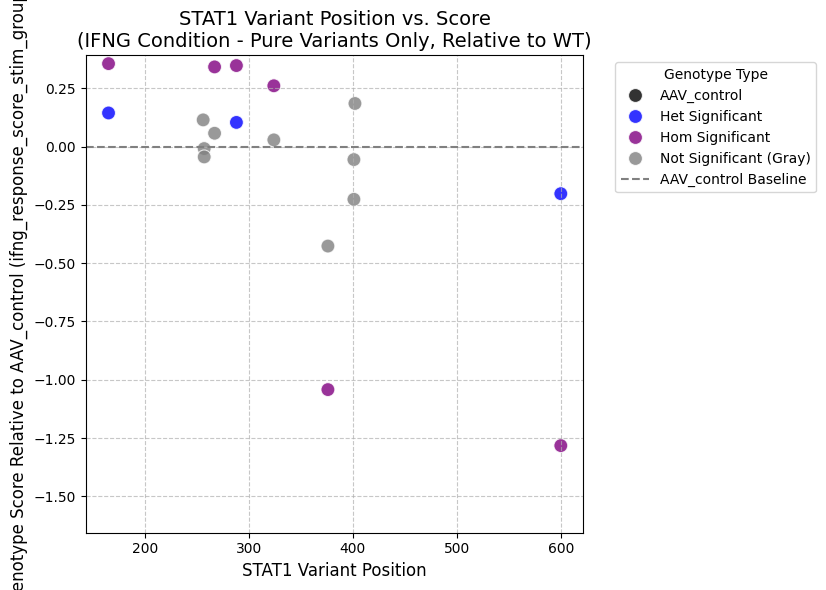


--- Generating plot for target gene: IFNGR1 ---

  Plotting data for IFNGR1 (head):
           genotype_label  position     score       p_value  allele_type  \
0             AAV_control       NaN  0.000000  1.000000e+00  AAV_control   
11   IFNGR1-SPA1_het_pure      30.0 -0.048211  4.938611e-01          het   
12   IFNGR1-SPA1_hom_pure      30.0 -1.505392  2.258470e-06          hom   
1    IFNGR1-C77Y_het_pure      77.0  0.027330  8.283905e-01          het   
2    IFNGR1-C77Y_hom_pure      77.0 -0.670546  8.978212e-04          hom   
7    IFNGR1-I87T_het_pure      87.0 -0.059431  4.861608e-05          het   
8    IFNGR1-I87T_hom_pure      87.0 -0.776985  7.709710e-88          hom   
13   IFNGR1-W89R_het_pure      89.0 -0.289490  1.127193e-02          het   
14   IFNGR1-W89R_hom_pure      89.0 -1.436094  1.162232e-68          hom   
9     IFNGR1-NC2_het_pure     125.0 -0.110518  1.014957e-02          het   
10    IFNGR1-NC2_hom_pure     125.0 -1.338599  8.602487e-67          hom   
3  

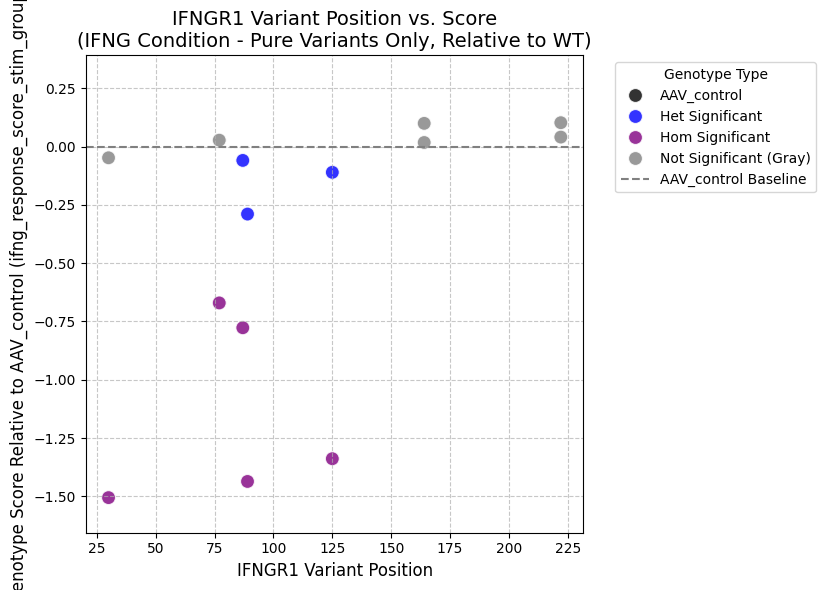


--- Generating plot for target gene: IFNGR2 ---

  Plotting data for IFNGR2 (head):
           genotype_label  position     score       p_value  allele_type  \
0             AAV_control       NaN  0.000000  1.000000e+00  AAV_control   
1    IFNGR2-D78N_het_pure      78.0  0.107186  4.174474e-01          het   
2    IFNGR2-D78N_hom_pure      78.0  0.208632  3.282181e-01          hom   
9    IFNGR2-Y82C_het_pure      82.0  0.043546  2.388839e-01          het   
10   IFNGR2-Y82C_hom_pure      82.0 -0.189692  1.109746e-15          hom   
3   IFNGR2-R136W_het_pure     136.0  0.056560  5.863216e-01          het   
4   IFNGR2-R136W_hom_pure     136.0 -0.016583  2.007061e-01          hom   
7    IFNGR2-SPD3_het_pure     157.0  0.046499  9.457351e-01          het   
8    IFNGR2-SPD3_hom_pure     157.0  0.152090  1.000000e+00          hom   
5   IFNGR2-R206G_het_pure     206.0  0.066076  7.685632e-01          het   
6   IFNGR2-R206G_hom_pure     206.0  0.150682  3.161511e-01          hom   

  

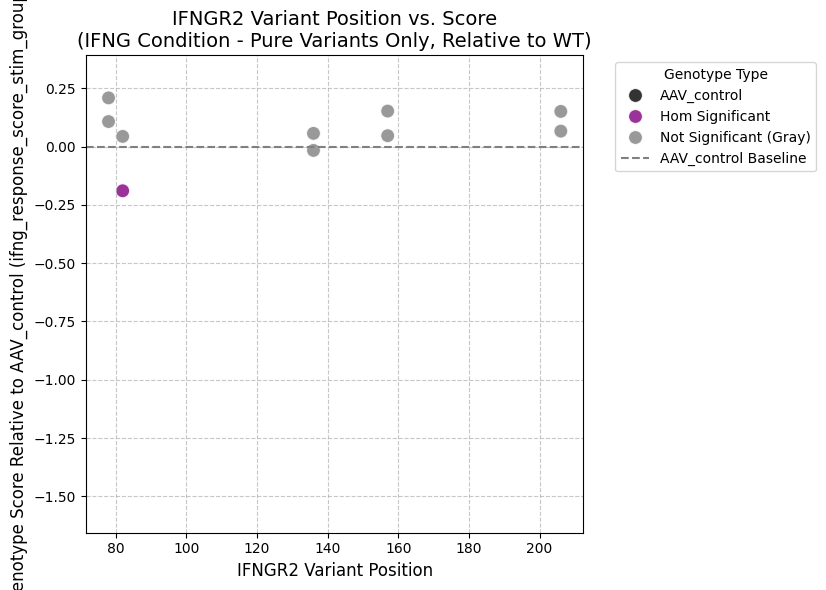


--- Generating plot for target gene: JAK1 ---

  Plotting data for JAK1 (head):
        genotype_label  position     score   p_value  allele_type  \
0          AAV_control       NaN  0.000000  1.000000  AAV_control   
1   JAK1-E83K_het_pure      83.0  0.069049  0.762603          het   
2   JAK1-E83K_hom_pure      83.0  0.177196  0.114310          hom   
5   JAK1-SPA5_het_pure     110.0 -0.040069  0.090244          het   
6   JAK1-SPA5_hom_pure     110.0 -0.877305  0.000001          hom   
7  JAK1-T147A_het_pure     147.0  0.081006  0.177768          het   
8  JAK1-T147A_hom_pure     147.0  0.166053  0.036420          hom   
3  JAK1-R360W_het_pure     360.0  0.081231  0.795087          het   
4  JAK1-R360W_hom_pure     360.0  0.049628  0.935871          hom   

      plot_color_category  
0             AAV_control  
1  Not Significant (Gray)  
2  Not Significant (Gray)  
5  Not Significant (Gray)  
6         Hom Significant  
7  Not Significant (Gray)  
8         Hom Significant  
3  N

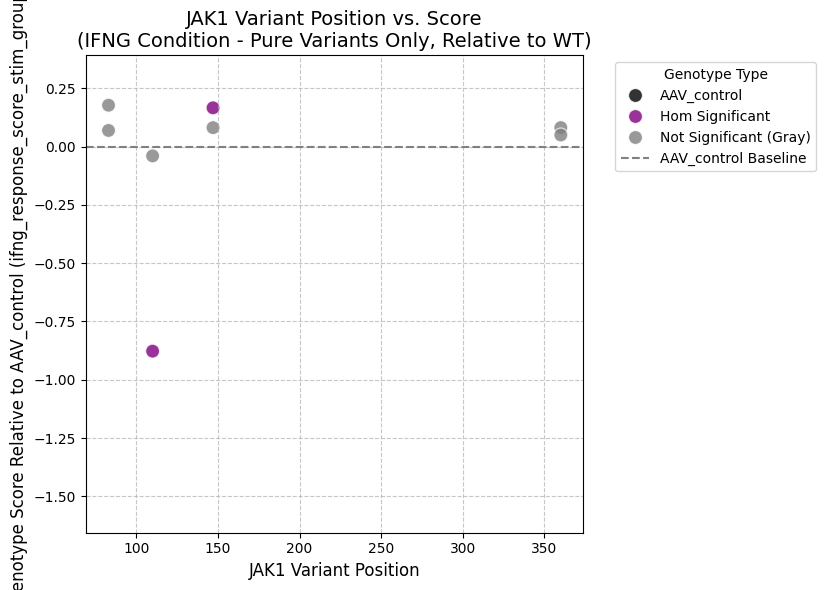


--- Generating plot for target gene: JAK2 ---

  Plotting data for JAK2 (head):
        genotype_label  position     score   p_value  allele_type  \
0          AAV_control       NaN  0.000000  1.000000  AAV_control   
1  JAK2-G281S_het_pure     281.0  0.042123  0.963310          het   
2  JAK2-G281S_hom_pure     281.0 -0.001791  1.000000          hom   
3  JAK2-R683G_het_pure     683.0  0.017121  0.503656          het   
4  JAK2-R683G_hom_pure     683.0  0.155396  0.001722          hom   
5  JAK2-R867Q_het_pure     867.0  0.024082  0.813424          het   
6  JAK2-R867Q_hom_pure     867.0  0.200272  0.588073          hom   

      plot_color_category  
0             AAV_control  
1  Not Significant (Gray)  
2  Not Significant (Gray)  
3  Not Significant (Gray)  
4         Hom Significant  
5  Not Significant (Gray)  
6  Not Significant (Gray)  
  Applying global Y-axis limits: [-1.66, 0.39]


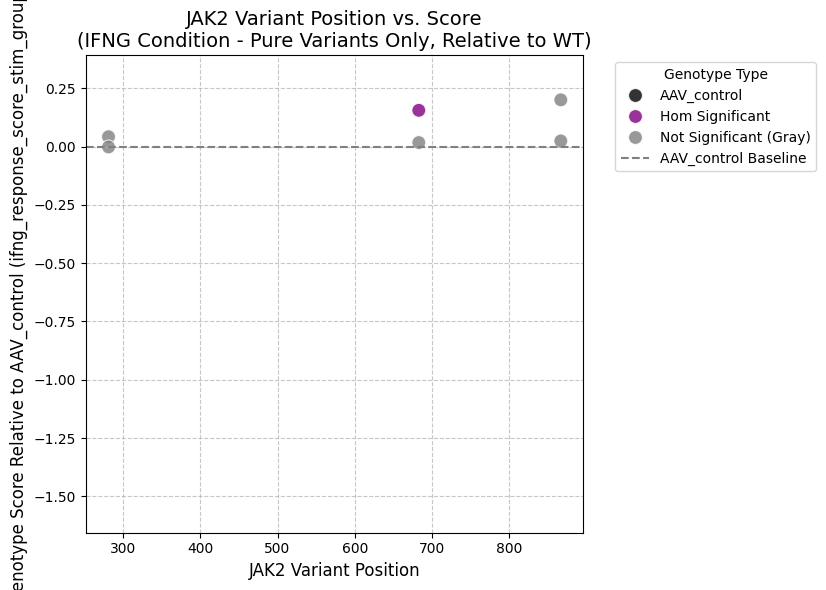


--- Generating plot for target gene: IRF1 ---

  Plotting data for IRF1 (head):
        genotype_label  position     score       p_value  allele_type  \
0          AAV_control       NaN  0.000000  1.000000e+00  AAV_control   
3   IRF1-W11R_het_pure      11.0  0.030004  4.601382e-01          het   
4   IRF1-W11R_hom_pure      11.0 -0.234896  7.915202e-24          hom   
1  IRF1-R129*_het_pure     129.0  0.061383  6.204331e-01          het   
2  IRF1-R129*_hom_pure     129.0 -0.036105  3.870524e-02          hom   

      plot_color_category  
0             AAV_control  
3  Not Significant (Gray)  
4         Hom Significant  
1  Not Significant (Gray)  
2         Hom Significant  
  Applying global Y-axis limits: [-1.66, 0.39]


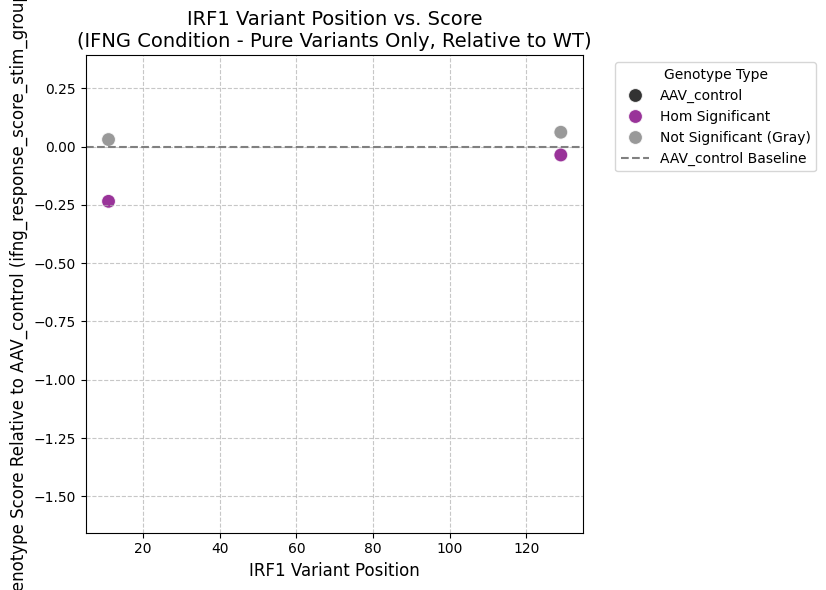


--- Genotype Position vs. Score Plots Generated Successfully ---
Loading combined mean score table: /mnt/data/project/25_08_25_rebuttal_analysis/fig3_stat1_het_pval/0_Top 100/ifng_scores_mean_per_genotype_0.csv
Loading combined p-value table: /mnt/data/project/25_08_25_rebuttal_analysis/fig3_stat1_het_pval/0_Top 100/ifng_scores_pvalues_vs_aavcontrol_FDR_corrected_0.csv
Combined mean and p-value tables loaded successfully.
Baseline 'AAV_control' score for IFNG ifng_response_score_anders: 0.8992

Processed combined data head (with relative scores):
                           raw_score   p_value  score_relative_to_aav
AAV_control                 0.899204  1.000000               0.000000
IFNGR1-C77Y_het_bystander   0.889022  0.093699              -0.010182
IFNGR1-C77Y_het_pure        0.930160  0.935871               0.030956
IFNGR1-C77Y_hom_bystander  -0.033694  0.000192              -0.932899
IFNGR1-C77Y_hom_pure        0.290257  0.001171              -0.608947

--- Determining Global Y-

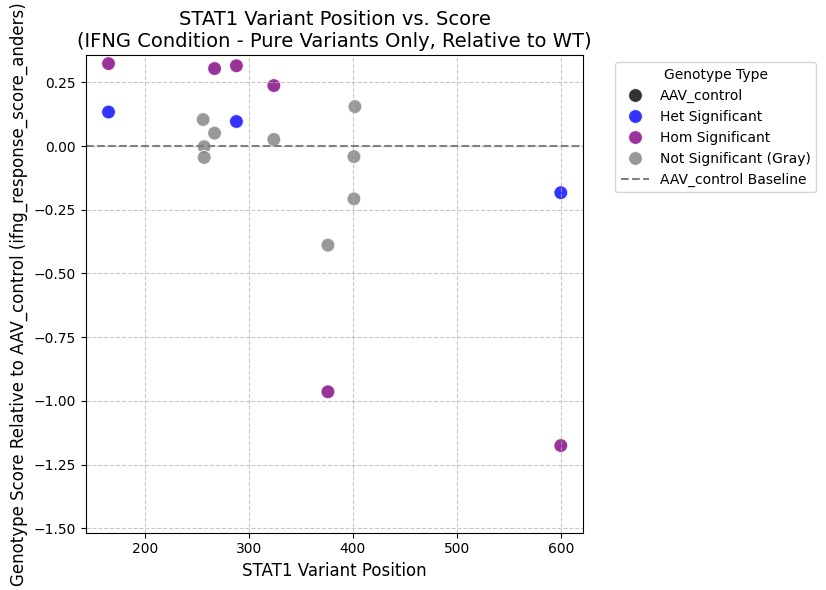


--- Generating plot for target gene: IFNGR1 ---

  Plotting data for IFNGR1 (head):
           genotype_label  position     score       p_value  allele_type  \
0             AAV_control       NaN  0.000000  1.000000e+00  AAV_control   
11   IFNGR1-SPA1_het_pure      30.0 -0.040423  5.866257e-01          het   
12   IFNGR1-SPA1_hom_pure      30.0 -1.379354  2.026566e-06          hom   
1    IFNGR1-C77Y_het_pure      77.0  0.030956  9.358709e-01          het   
2    IFNGR1-C77Y_hom_pure      77.0 -0.608947  1.171180e-03          hom   
7    IFNGR1-I87T_het_pure      87.0 -0.051626  8.104749e-05          het   
8    IFNGR1-I87T_hom_pure      87.0 -0.707750  1.473174e-87          hom   
13   IFNGR1-W89R_het_pure      89.0 -0.262684  1.426633e-02          het   
14   IFNGR1-W89R_hom_pure      89.0 -1.314105  1.123842e-68          hom   
9     IFNGR1-NC2_het_pure     125.0 -0.101565  1.030049e-02          het   
10    IFNGR1-NC2_hom_pure     125.0 -1.226571  7.606719e-67          hom   
3  

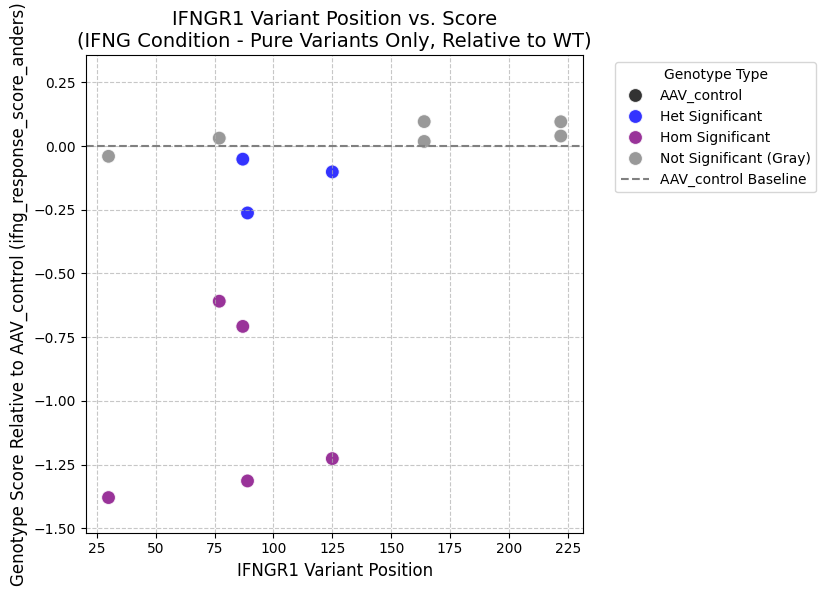


--- Generating plot for target gene: IFNGR2 ---

  Plotting data for IFNGR2 (head):
           genotype_label  position     score       p_value  allele_type  \
0             AAV_control       NaN  0.000000  1.000000e+00  AAV_control   
1    IFNGR2-D78N_het_pure      78.0  0.100699  3.784008e-01          het   
2    IFNGR2-D78N_hom_pure      78.0  0.184783  3.557018e-01          hom   
9    IFNGR2-Y82C_het_pure      82.0  0.041266  2.861167e-01          het   
10   IFNGR2-Y82C_hom_pure      82.0 -0.172392  9.654752e-16          hom   
3   IFNGR2-R136W_het_pure     136.0  0.054283  6.508181e-01          het   
4   IFNGR2-R136W_hom_pure     136.0 -0.011207  2.313046e-01          hom   
7    IFNGR2-SPD3_het_pure     157.0  0.041264  9.457351e-01          het   
8    IFNGR2-SPD3_hom_pure     157.0  0.121803  1.000000e+00          hom   
5   IFNGR2-R206G_het_pure     206.0  0.062221  6.778776e-01          het   
6   IFNGR2-R206G_hom_pure     206.0  0.136632  3.284924e-01          hom   

  

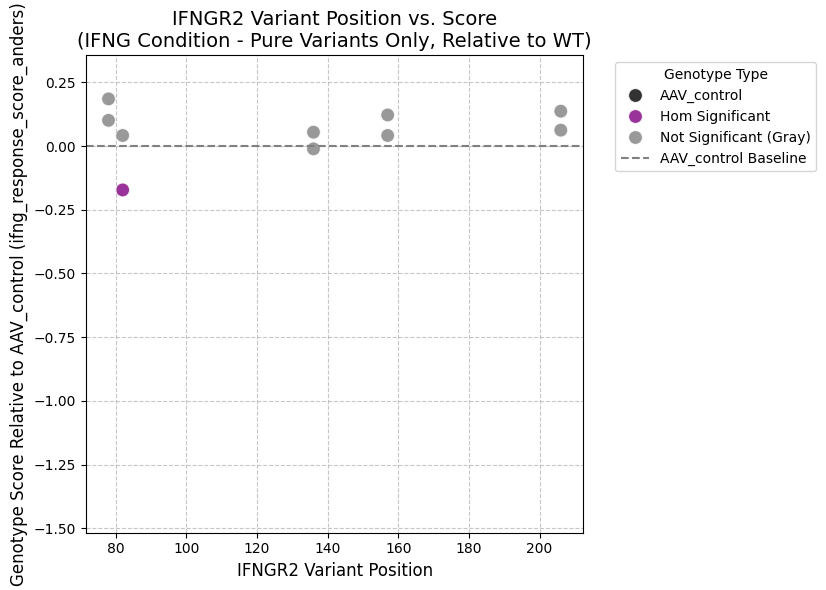


--- Generating plot for target gene: JAK1 ---

  Plotting data for JAK1 (head):
        genotype_label  position     score   p_value  allele_type  \
0          AAV_control       NaN  0.000000  1.000000  AAV_control   
1   JAK1-E83K_het_pure      83.0  0.065062  0.724481          het   
2   JAK1-E83K_hom_pure      83.0  0.164335  0.102172          hom   
5   JAK1-SPA5_het_pure     110.0 -0.035397  0.102172          het   
6   JAK1-SPA5_hom_pure     110.0 -0.801381  0.000001          hom   
7  JAK1-T147A_het_pure     147.0  0.075006  0.160317          het   
8  JAK1-T147A_hom_pure     147.0  0.152886  0.033196          hom   
3  JAK1-R360W_het_pure     360.0  0.074129  0.804991          het   
4  JAK1-R360W_hom_pure     360.0  0.048001  0.874585          hom   

      plot_color_category  
0             AAV_control  
1  Not Significant (Gray)  
2  Not Significant (Gray)  
5  Not Significant (Gray)  
6         Hom Significant  
7  Not Significant (Gray)  
8         Hom Significant  
3  N

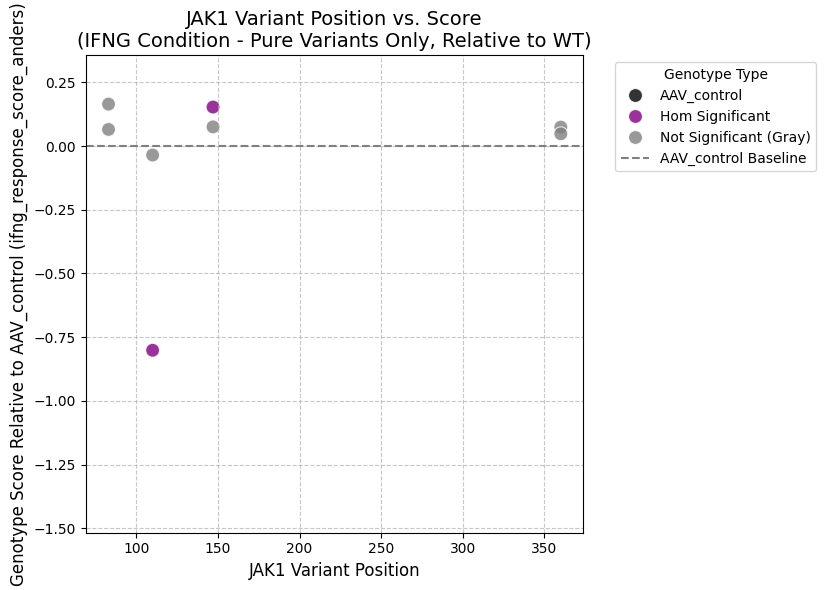


--- Generating plot for target gene: JAK2 ---

  Plotting data for JAK2 (head):
        genotype_label  position     score   p_value  allele_type  \
0          AAV_control       NaN  0.000000  1.000000  AAV_control   
1  JAK2-G281S_het_pure     281.0  0.040845  0.961766          het   
2  JAK2-G281S_hom_pure     281.0  0.005058  1.000000          hom   
3  JAK2-R683G_het_pure     683.0  0.016853  0.458688          het   
4  JAK2-R683G_hom_pure     683.0  0.142464  0.001136          hom   
5  JAK2-R867Q_het_pure     867.0  0.020360  0.818307          het   
6  JAK2-R867Q_hom_pure     867.0  0.185948  0.581726          hom   

      plot_color_category  
0             AAV_control  
1  Not Significant (Gray)  
2  Not Significant (Gray)  
3  Not Significant (Gray)  
4         Hom Significant  
5  Not Significant (Gray)  
6  Not Significant (Gray)  
  Applying global Y-axis limits: [-1.52, 0.36]


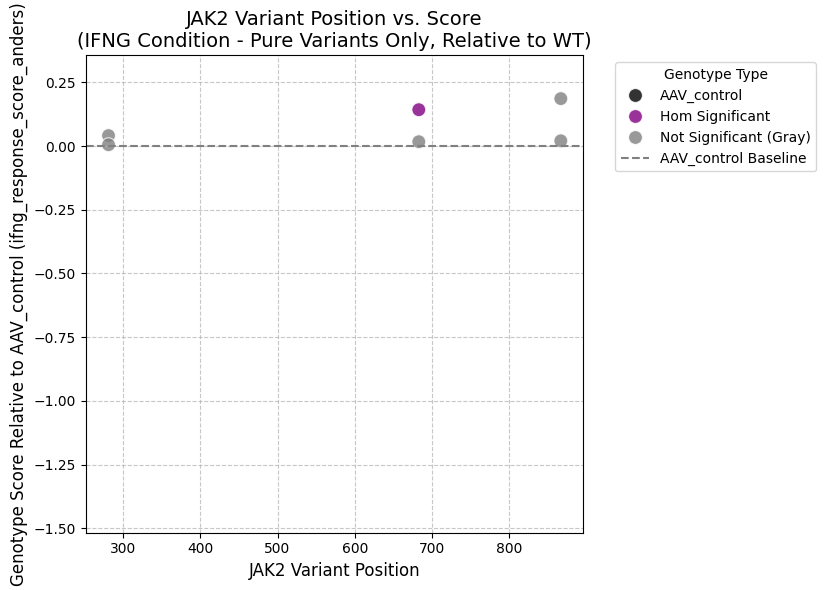


--- Generating plot for target gene: IRF1 ---

  Plotting data for IRF1 (head):
        genotype_label  position     score       p_value  allele_type  \
0          AAV_control       NaN  0.000000  1.000000e+00  AAV_control   
3   IRF1-W11R_het_pure      11.0  0.025892  4.601382e-01          het   
4   IRF1-W11R_hom_pure      11.0 -0.218083  2.893082e-24          hom   
1  IRF1-R129*_het_pure     129.0  0.057710  6.462465e-01          het   
2  IRF1-R129*_hom_pure     129.0 -0.035083  3.340265e-02          hom   

      plot_color_category  
0             AAV_control  
3  Not Significant (Gray)  
4         Hom Significant  
1  Not Significant (Gray)  
2         Hom Significant  
  Applying global Y-axis limits: [-1.52, 0.36]


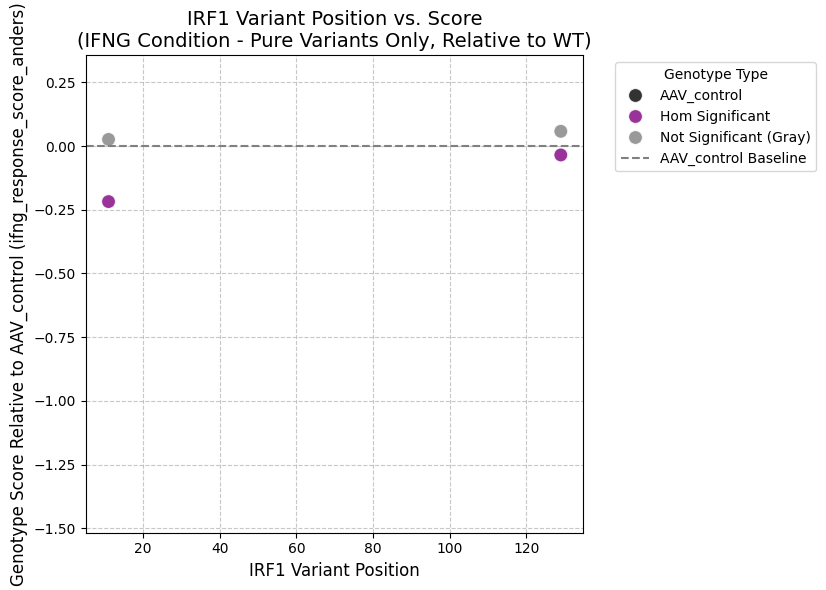


--- Genotype Position vs. Score Plots Generated Successfully ---


In [6]:
# make the scatter plot for the ifng score to show 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

# --- Configuration ---

# 1. Paths to  COMBINED mean score table (already averaged across donors)
#    This table should have 'Condition', 'Score_Source' as a multi-index (or columns that can be set as such)
#    and genotype names as columns, with the averaged scores as values.
combined_mean_score_table = f"/mnt/data/project/25_08_25_rebuttal_analysis/fig3_stat1_het_pval/{donor}_{gene_list}/ifng_scores_mean_per_genotype_{donor}.csv" # Example: This would contain mean scores for ALL donors
# 2. Paths to  COMBINED p-value table (e.g., from an analysis that combines donors for significance)
combined_pvalue_table = f"/mnt/data/project/25_08_25_rebuttal_analysis/fig3_stat1_het_pval/{donor}_{gene_list}/ifng_scores_pvalues_vs_aavcontrol_FDR_corrected_{donor}.csv"

# 3. Select the specific condition and score method to plot
selected_condition = 'IFNG' # e.g., 'PBS' or 'IFNG'
selected_score_method = 'ifng_response_score_z' # e.g., 'ifng_response_score_raw', 'ifng_response_score_z', 'mixscale_ifng_score_zstd'

# 4. List of target genes (proteins) to focus on for plotting
target_genes_to_plot = ['STAT1', 'IFNGR1', 'IFNGR2', 'JAK1', 'JAK2', "IRF1"] # Add all proteins you want to plot

# 5. Manual mapping for tricky position annotations (e.g., splicing variants, non-numeric labels)
#    Format: {'GENE-VARIANT_LABEL': POSITION_NUMBER}
manual_positions_map = {
    'STAT1-NC1': 376,
    'IFNGR1-NC2': 125,
    'IFNGR1-SPA1': 30,
    'IFNGR2-SPD3': 157,
    'JAK1-SPA5': 110
}

# 6. Genotype naming conventions (for parsing)
het_keyword = 'het'
hom_keyword = 'hom'
bystander_keyword = 'bystander' # Keyword to identify bystander genotypes (to be ignored)

# 7. Non-variant genotypes to exclude from parsing (e.g., AAV_control, unedited)
non_variant_genotypes = ['AAV_control', 'unedited', 'mixed']
wt_genotype_label = 'AAV_control' # Explicitly define WT label for baseline

# 8. P-value threshold for significance coloring
pval_threshold = 0.05

# 9. Output directory for plots

for selected_score_method in ['ifng_response_score_z','ifng_response_score_stim_group','ifng_response_score_anders']:
    output_dir = Path(f"/mnt/data/project/25_08_25_rebuttal_analysis/fig3_stat1_het_pval/{donor}_{gene_list}/plot_{selected_score_method}") # Updated output directory
    output_dir.mkdir(parents=True, exist_ok=True)

    # --- Load Data and Prepare Combined Scores ---
    print(f"Loading combined mean score table: {combined_mean_score_table}")
    print(f"Loading combined p-value table: {combined_pvalue_table}")
    try:
        # Load the combined mean score table
        df_combined_mean = pd.read_csv(combined_mean_score_table, index_col=[0, 1])
        # Load the combined p-value table
        df_combined_pvals = pd.read_csv(combined_pvalue_table, index_col=0)
        print("Combined mean and p-value tables loaded successfully.")

        # Construct the index to locate the correct row in the mean score table
        mean_score_idx = (selected_condition, selected_score_method)
        # Construct the index to locate the correct row in the p-value table
        pval_row_idx = f"{selected_condition}_{selected_score_method}" # This matches how pval table is structured

        # Get the Series of combined scores for the selected row
        average_scores_series_raw = df_combined_mean.loc[mean_score_idx].squeeze()
        # Get the Series of combined p-values for the selected row
        pvalues_series_raw = df_combined_pvals.loc[pval_row_idx].squeeze()
        
        # Handle cases where squeeze might return a DataFrame
        if isinstance(average_scores_series_raw, pd.DataFrame): 
            if average_scores_series_raw.shape[0] > 1:
                print(f"Warning: Multiple score rows found for {mean_score_idx}. Taking the first one.")
            average_scores_series_raw = average_scores_series_raw.iloc[0]
        if isinstance(pvalues_series_raw, pd.DataFrame):
            if pvalues_series_raw.shape[0] > 1:
                print(f"Warning: Multiple p-value rows found for {pval_row_idx}. Taking the first one.")
            pvalues_series_raw = pvalues_series_raw.iloc[0]


        # --- Combine scores and p-values into a single temporary DataFrame indexed by genotype ---
        # Do NOT dropna() immediately on p_value, to preserve AAV_control.
        temp_combined_df = pd.DataFrame({
            'raw_score': average_scores_series_raw,
            'p_value': pvalues_series_raw 
        })

        # if p_value is NaN, it means no test was performed (e.g., insufficient cells), so we keep it as NaN
        # we then set it to 1
        temp_combined_df['p_value'] = temp_combined_df['p_value'].fillna(1.0)

        # Ensure AAV_control is present and has a p-value of 1.0 (as it's the reference)
        if wt_genotype_label in average_scores_series_raw.index and wt_genotype_label not in temp_combined_df.index:
            temp_combined_df.loc[wt_genotype_label, 'raw_score'] = average_scores_series_raw.loc[wt_genotype_label]
            temp_combined_df.loc[wt_genotype_label, 'p_value'] = 1.0 # Explicitly set p-value to 1.0 for self-comparison
        elif wt_genotype_label in temp_combined_df.index:
            temp_combined_df.loc[wt_genotype_label, 'p_value'] = 1.0
        else:
            print(f"Error: WT genotype '{wt_genotype_label}' not found in any source data for this condition/score. Cannot set baseline. Exiting.")
            exit()

        # Now, drop NaNs based on the 'raw_score' column only.
        temp_combined_df = temp_combined_df.dropna(subset=['raw_score'])
        
        # import pdb; pdb.set_trace()
        if temp_combined_df.empty:
            print("Error: No common genotypes with complete score data found for the selected condition/score method after filtering. Exiting.")
            exit()

        # --- Baseline Transformation: Subtract AAV_control score ---
        aav_control_score_baseline = temp_combined_df.loc[wt_genotype_label, 'raw_score']
        print(f"Baseline '{wt_genotype_label}' score for {selected_condition} {selected_score_method}: {aav_control_score_baseline:.4f}")
        
        temp_combined_df['score_relative_to_aav'] = temp_combined_df['raw_score'] - aav_control_score_baseline

        print(f"\nProcessed combined data head (with relative scores):")
        print(temp_combined_df.head())
        temp_combined_df.to_csv(output_dir / f'combined_scores_relative_to_{wt_genotype_label}_{selected_condition}_{selected_score_method}_pure_only.csv')

    except KeyError as e:
        print(f"Error: Missing key in loaded tables. Check condition/score method/WT label: {e}.")
        exit()
    except FileNotFoundError as e:
        print(f"Error loading combined tables: {e}. Please check paths.")
        exit()
    except Exception as e:
        print(f"An unexpected error occurred during data loading and initial processing: {e}. Exiting.")
        exit()

    # --- NEW: Determine Global Y-axis Limits ---
    print("\n--- Determining Global Y-axis Limits for consistent plotting ---")

    all_relevant_scores = []

    # Regex to parse GENE-MUTATION_DETAILS_SUFFIX (e.g., STAT1-L600P_het_pure)
    # Gene symbol part (Group 1), Mutation detail part (Group 2), Suffix part (Group 3)
    variant_label_parser = re.compile(r'([A-Za-z0-9]+)-([A-Za-z0-9\*-]+)_(.*)') # More robust for mutation details like Q329*

    for genotype_full_label, row in temp_combined_df.iterrows():
        # Only consider variant genotypes (not AAV_control or other non-variants)
        if genotype_full_label == wt_genotype_label or genotype_full_label in non_variant_genotypes or \
        bystander_keyword in genotype_full_label.lower():
            continue

        # Attempt to parse the genotype label
        match_label_parts = variant_label_parser.match(genotype_full_label)
        
        if not match_label_parts:
            continue 
        current_gene_symbol = match_label_parts.group(1)

        # Only consider scores for proteins that are in our target_genes_to_plot list
        if current_gene_symbol in target_genes_to_plot:
            all_relevant_scores.append(row['score_relative_to_aav'])

    # Also include the AAV_control's relative score (which is 0) in the range
    all_relevant_scores.append(0.0)

    if not all_relevant_scores:
        print("Warning: No relevant scores found to determine global Y-axis limits. Plots may have default scaling.")
        global_y_min, global_y_max = None, None
    else:
        global_y_min = np.min(all_relevant_scores) * 1.1 # Add a bit of padding
        global_y_max = np.max(all_relevant_scores) * 1.1 # Add a bit of padding
        # Ensure 0 is always within the range
        if global_y_min > 0: global_y_min = -global_y_max * 0.1
        if global_y_max < 0: global_y_max = -global_y_min * 0.1
        if 0 < global_y_min: global_y_min = -0.1
        if 0 > global_y_max: global_y_max = 0.1


        print(f"  Global Y-axis limits: [{global_y_min:.2f}, {global_y_max:.2f}]")


    # --- Main Loop for Generating Plots per Target Protein ---
    for target_gene in target_genes_to_plot:
        print(f"\n--- Generating plot for target gene: {target_gene} ---")

        plot_data = []

        # Regex to find the first sequence of digits within a string (for position extraction)
        position_extractor = re.compile(r'(\d+)')
        # Regex to parse GENE-MUTATION_DETAILS_SUFFIX (e.g., STAT1-L600P_het_pure)
        # Gene symbol part (Group 1), Mutation detail part (Group 2), Suffix part (Group 3)
        variant_label_parser = re.compile(r'([A-Za-z0-9]+)-([A-Za-z0-9\*-]+)_(.*)') # More robust for mutation details like Q329*

        for genotype_full_label, row in temp_combined_df.iterrows():
            # Keep AAV_control as a special point for every plot
            if genotype_full_label == wt_genotype_label:
                plot_data.append({
                    'genotype_label': genotype_full_label,
                    'position': np.nan, # AAV_control has no variant position
                    'score': row['score_relative_to_aav'],
                    'p_value': row['p_value'],
                    'allele_type': 'AAV_control', # Special type for coloring
                    'plot_color_category': 'AAV_control'
                })
                continue

            # Skip other non-variant labels (unedited, mixed, etc.)
            if genotype_full_label in non_variant_genotypes:
                continue

            # Filter: Skip bystander genotypes
            if bystander_keyword in genotype_full_label.lower():
                continue

            # Parse the genotype label
            match_label_parts = variant_label_parser.match(genotype_full_label)
            
            if not match_label_parts:
                # print(f"  Warning: Genotype label '{genotype_full_label}' did not match expected 'GENE-MUTATION_SUFFIX' pattern. Skipping.")
                continue # Skip if basic structure not matched

            current_gene_symbol = match_label_parts.group(1)
            mutation_details_part = match_label_parts.group(2) # e.g., 'L600P' or 'NC1'
            genotype_suffix = match_label_parts.group(3) # e.g., 'het_pure'


            if current_gene_symbol != target_gene:
                continue # Skip if not the current target gene for this plot

            # --- Extract Position ---
            position = None
            
            # 1. Check manual mapping first
            manual_key = f"{current_gene_symbol}-{mutation_details_part}"
            if manual_key in manual_positions_map:
                position = manual_positions_map[manual_key]
                # print(f"  Using manual position for {manual_key}: {position}")
            else:
                # 2. Fallback to regex for numerical position
                position_match = position_extractor.search(mutation_details_part)
                if position_match:
                    try:
                        position = int(position_match.group(1))
                    except ValueError:
                        print(f"  Warning: Could not convert position '{position_match.group(1)}' to integer for '{genotype_full_label}'. Skipping.")
                        continue
                else:
                    # print(f"  Warning: No numerical position found in '{mutation_details_part}' for '{genotype_full_label}'. Skipping.")
                    continue # Skip if no position found (neither manual nor regex)

            # --- Determine Allele Type (het/hom) ---
            allele_type = None
            if het_keyword in genotype_full_label.lower(): # Check in full label for safety
                allele_type = 'het'
            elif hom_keyword in genotype_full_label.lower(): # Check in full label for safety
                allele_type = 'hom'
            
            if allele_type is None:
                # print(f"  Warning: Could not determine 'het' or 'hom' for '{genotype_full_label}'. Skipping.")
                continue # Skip if neither het nor hom keyword is found
            
            # --- Determine Plotting Color Category based on p-value and allele type ---
            plot_color_category = None

            # if p-value is NaN (should not happen here since we filtered NaNs earlier), treat as not significant
            
            if row['p_value'] > pval_threshold:
                plot_color_category = 'Not Significant (Gray)'
            else: # Significant
                if allele_type == 'het':
                    plot_color_category = 'Het Significant'
                elif allele_type == 'hom':
                    plot_color_category = 'Hom Significant'
                else: # Fallback, should not happen if allele_type is already het/hom
                    plot_color_category = 'Other Significant Variant'
                    
            # If all parsing and filtering is successful, add to plot_data
            plot_data.append({
                'genotype_label': genotype_full_label,
                'position': position,
                'score': row['score_relative_to_aav'],
                'p_value': row['p_value'],
                'allele_type': allele_type, # Keep het/hom
                'plot_color_category': plot_color_category
            })

        if not plot_data:
            print(f"  No data points found for '{target_gene}' after parsing and filtering. Skipping plot for this gene.")
            continue # Skip to next target_gene

        plot_df = pd.DataFrame(plot_data)
        # Sort to ensure AAV_control is first for legend and plotting order, then by position
        plot_df['position_sort_key'] = plot_df['position'].fillna(-1) # Use -1 for AAV_control to sort it first
        
        plot_df = plot_df.sort_values(by=['position_sort_key']).drop(columns='position_sort_key')

        print(f"\n  Plotting data for {target_gene} (head):")
        print(plot_df)

        # --- Plotting ---
        plt.figure(figsize=(10, 6))

        # Define custom palette
        custom_palette_full = {
            'AAV_control': 'black', # Special color for WT baseline
            'Not Significant (Gray)': 'gray',
            'Het Significant': 'blue',
            'Hom Significant': 'purple',
            'Other Significant Variant': 'green' # Fallback color
        }

        # Ensure plot_color_category is a categorical type with the desired order for legend
        category_order = ['AAV_control', 'Het Significant', 'Hom Significant', 
                        'Not Significant (Gray)', 'Other Significant Variant']
        plot_df['plot_color_category'] = pd.Categorical(
            plot_df['plot_color_category'], 
            categories=[c for c in category_order if c in plot_df['plot_color_category'].unique()], 
            ordered=True
        )

        sns.scatterplot(
            data=plot_df,
            x='position',
            y='score',
            hue='plot_color_category',
            palette=custom_palette_full,
            s=100, # Size of points
            alpha=0.8,
            legend='full'
        )

        # Add baseline at y=0
        plt.axhline(0, color='grey', linestyle='--', lw=1.5, label=f'{wt_genotype_label} Baseline')

        plt.xlabel(f'{target_gene} Variant Position', fontsize=12)
        plt.ylabel(f'Genotype Score Relative to {wt_genotype_label} ({selected_score_method})', fontsize=12)
        plt.title(f'{target_gene} Variant Position vs. Score\n({selected_condition} Condition - Pure Variants Only, Relative to WT)', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Set common Y-axis limits
        if global_y_min is not None and global_y_max is not None:
            plt.ylim(global_y_min, global_y_max)
            print(f"  Applying global Y-axis limits: [{global_y_min:.2f}, {global_y_max:.2f}]")


        # Adjust legend: place AAV_control separately or ensure clarity
        handles, labels = plt.gca().get_legend_handles_labels()
        # Filter out the automatically added 'AAV_control Baseline' label from the scatter legend
        filtered_handles = [h for i, h in enumerate(handles) if labels[i] != f'{wt_genotype_label} Baseline']
        filtered_labels = [l for l in labels if l != f'{wt_genotype_label} Baseline']

        # Manually add the baseline legend item
        baseline_handle = plt.Line2D([0], [0], color='grey', lw=1.5, linestyle='--')
        filtered_handles.append(baseline_handle)
        filtered_labels.append(f'{wt_genotype_label} Baseline')


        plt.legend(filtered_handles, filtered_labels, title='Genotype Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust for legend

        output_plot_file_current_gene = output_dir / f'{target_gene}_Position_vs_Score_RelativeToWT_{selected_condition}_{selected_score_method.replace("mixscale_ifng_score_", "")}_PureOnly.png'
        plt.savefig(output_plot_file_current_gene, dpi=300, bbox_inches='tight')
        plt.show()

    print("\n--- Genotype Position vs. Score Plots Generated Successfully ---")
